# Analyze SickKids data over sessions

For each of the derivative data, we will perform two analyses:

1. Load all data and normalize with respect to fragility and show these over four sessions.

2. Load all data and normalize with respect to a null distribution and show these four sessions over all electrodes

In [24]:
import numpy as np
import pandas as pd
import mne
import os
import json
import os.path as op
from pathlib import Path

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath
import mne
mne.utils.use_log_level('error')
import seaborn as sns
import matplotlib.pyplot as plt

from eztrack.io.base import _add_desc_to_bids_fname
from eztrack.io import read_derivative_npy
from eztrack.fragility import lds_raw_fragility, DiscreteLinearSystem
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

_load_turbo()

%matplotlib inline

In [85]:
# load in originally ran npy data
root = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/')
deriv_root = root / 'derivatives'
reference = 'monopolar'
deriv_chain = Path('originalsampling') / 'radius1.5' / 'fragility' / reference

subject = 'E7'
sessions = ['extraoperative', 'preresection', 
            'intraresection', 'postresection']
desc = 'perturbmatrix'

# derivative path
deriv_path = deriv_root / deriv_chain / f'sub-{subject}'

deriv_data_mean = []
deriv_data_std = []
session_marks = dict()
session_data = []

derivs = None
for session in sessions:
    pattern = f'*ses-{session}*desc-{desc}*.json'

    # get all json paths
    fpaths = list(deriv_path.glob(pattern))
    
    for idx, fpath in enumerate(fpaths):
        perturb_deriv = read_derivative_npy(fpath, preload=True, verbose=False)
        if idx == 0:
            derivs = perturb_deriv
        else:
            derivs.append(perturb_deriv)
        perturb_deriv.normalize()
        frag_mat = perturb_deriv.get_data()
#         print(perturb_deriv)
#         deriv_data.extend(perturb_deriv.get_data())
        
        deriv_data_mean.extend(frag_mat.mean(axis=0))
        deriv_data_std.extend(frag_mat.std(axis=0))
        session_marks[session] = len(deriv_data_mean)
        
        session_data.append(perturb_deriv)
        break
        
deriv_data_mean = np.array(deriv_data_mean)
deriv_data_std = np.array(deriv_data_std)

print(deriv_data_mean.shape)

<DerivativeNumpy | sub-E7_ses-preresection_task-Pre_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, 111 x 1243 (151.5 s), ~1.3 MB, data loaded>
<DerivativeNumpy | sub-E7_ses-postresection_task-Post_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, 70 x 1343 (163.7 s), ~918 kB, data loaded>
(2586,)


/Users/adam2392/Documents/eztrack/eztrack/io/npy/npy.py:181: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'AD1', 'AD2', 'AD3', 'AD4', 'AD5', 'AD6', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'TOD1', 'TOD2', 'TOD3', 'TOD4', 'TOD5', 'TOD6', 'POD1', 'POD2', 'POD3', 'POD4', 'POD5', 'POD6', 'FOD1', 'FOD2', 'FOD3', 'FOD4', 'FOD5', 'FOD6', 'ATPS1', 'ATPS2', 'ATPS3', 'ATPS4', 'ATPS5', 'ATPS6', 'ABTS1', 'ABTS2', 'ABTS3', 'ABTS4', 'ABTS5', 'ABTS6', 'PBTS1', 'PBTS2', 'PBTS3', 'PBTS4', 'PBTS5', 'PBTS6', 'C113', 'C114', 'C115', 'C116

In [86]:
# fig, ax = plt.subplots()

# ax.plot(deriv_data_mean)
# ax.fill_between(np.arange(len(deriv_data_mean)), 
#                 deriv_data_mean - deriv_data_std, 
#                 deriv_data_mean + deriv_data_std, color='blue',
#                alpha=0.5)
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# for idx, (label, vline) in enumerate(session_marks.items()):
#     color = colors[idx]
#     ax.axvline(vline, label=label, color=color)
# ax.legend()
# ax.set(
#     xlabel='Time (A.U.)',
#     ylabel='Normalized Fragility (Mean +/- Std)',
#     title=f'{subject} - {reference}',
#     ylim=[0,1],
# )
# figure_fpath = deriv_root / 'figures' / 'concatenated-sessions' /  f'{subject}-allsessions-{reference}.png'
# figure_fpath.parent.mkdir(exist_ok=True, parents=True)
# fig.savefig(figure_fpath)

# Only look at upper quantiles

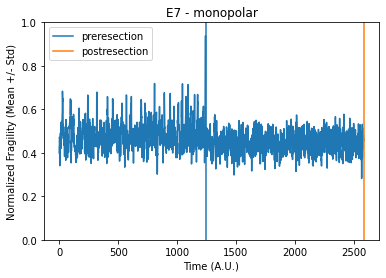

In [87]:
fig, ax = plt.subplots()

deriv_data_mean = []
for ses_deriv in session_data:
    deriv_data_mean.extend(np.quantile(ses_deriv.get_data(), 0.9, axis=0))
    
ax.plot(deriv_data_mean)
# ax.fill_between(np.arange(len(deriv_data_mean)), 
#                 deriv_data_mean - deriv_data_std, 
#                 deriv_data_mean + deriv_data_std, color='blue',
#                alpha=0.5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for idx, (label, vline) in enumerate(session_marks.items()):
    color = colors[idx]
    ax.axvline(vline, label=label, color=color)
ax.legend()
ax.set(
    xlabel='Time (A.U.)',
    ylabel='Normalized Fragility (Mean +/- Std)',
    title=f'{subject} - {reference}',
    ylim=[0,1],
)
figure_fpath = deriv_root / 'figures' / 'concatenated-sessions' /  f'{subject}-allsessions-{reference}.png'
figure_fpath.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(figure_fpath)

